In [ ]:
# LOGISTIC REGRESSION

2025-04-08 21:07:23,966 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|30/30, best_cost=0.17
2025-04-08 21:07:26,716 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.17045454545454541, best pos: [1.18446001 0.67341559 0.80282889 1.21190688]


Selected Features: ['age', 'result', 'A1_Score', 'A2_Score']
Training Accuracy: 0.8954
Test Accuracy: 0.8295
F-beta Score: 0.7391

Confusion Matrix:
 [[129   0]
 [ 30  17]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90       129
           1       1.00      0.36      0.53        47

    accuracy                           0.83       176
   macro avg       0.91      0.68      0.71       176
weighted avg       0.86      0.83      0.80       176



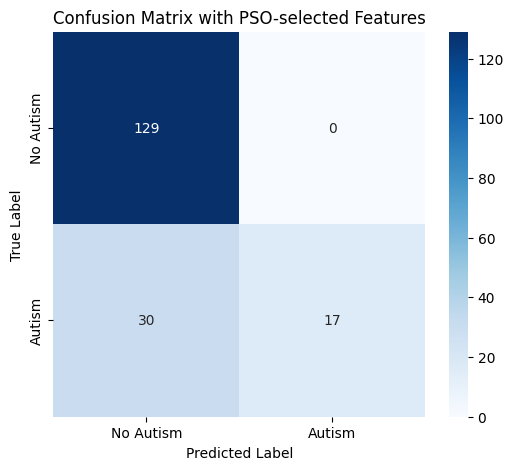

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from pyswarms.single.global_best import GlobalBestPSO

# Load dataset
data = pd.read_csv("autism_data.csv")
data.dropna(inplace=True)

# Define target and initial features
target = data['Class/ASD'].map({'YES': 1, 'NO': 0})
features = data[['age', 'result', 'A1_Score', 'A2_Score']].copy()

# Normalize numerical features
scaler = MinMaxScaler()
features[['age', 'result']] = scaler.fit_transform(features[['age', 'result']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, stratify=target, random_state=42)

# Add noise to numeric features
X_train[['age', 'result']] += np.random.normal(0, 0.02, X_train[['age', 'result']].shape)

# Fitness function for PSO
def fitness_function(particles):
    n_particles = particles.shape[0]
    scores = []

    for i in range(n_particles):
        mask = particles[i] > 0.5
        if np.count_nonzero(mask) == 0:
            scores.append(1)  # Penalize empty selection
            continue

        X_sel = X_train.iloc[:, mask]
        model = LogisticRegression(max_iter=500, C=0.1)
        model.fit(X_sel, y_train)
        y_pred = model.predict(X_test.iloc[:, mask])
        acc = accuracy_score(y_test, y_pred)
        scores.append(1 - acc)  # Minimize 1 - accuracy

    return np.array(scores)

# Run PSO
n_features = X_train.shape[1]
optimizer = GlobalBestPSO(n_particles=10, dimensions=n_features, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9})
cost, pos = optimizer.optimize(fitness_function, iters=30)

# Final model with selected features
selected_mask = pos > 0.5
selected_features = X_train.columns[selected_mask]
print("Selected Features:", list(selected_features))

X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

final_model = LogisticRegression(max_iter=500, C=0.1)
final_model.fit(X_train_sel, y_train)
y_pred = final_model.predict(X_test_sel)

# Evaluation
from sklearn.metrics import fbeta_score, confusion_matrix, classification_report

train_acc = accuracy_score(y_train, final_model.predict(X_train_sel))
test_acc = accuracy_score(y_test, y_pred)
fbeta = fbeta_score(y_test, y_pred, beta=0.5, zero_division=1)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Training Accuracy:", round(train_acc, 4))
print("Test Accuracy:", round(test_acc, 4))
print("F-beta Score:", round(fbeta, 4))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Autism', 'Autism'], yticklabels=['No Autism', 'Autism'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix with PSO-selected Features")
plt.show()


In [ ]:
#                                             SVM with PSO

Stopping search: maximum iterations reached --> 30
Selected Feature Indices: [0 1 3 6 7 9]
Selected Feature Names: ['id', 'A1_Score', 'A3_Score', 'A6_Score', 'A7_Score', 'A9_Score']
Training Accuracy: 0.8369
Test Accuracy: 0.8983
Confusion Matrix:
 [[36  3]
 [ 3 17]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        39
           1       0.85      0.85      0.85        20

    accuracy                           0.90        59
   macro avg       0.89      0.89      0.89        59
weighted avg       0.90      0.90      0.90        59



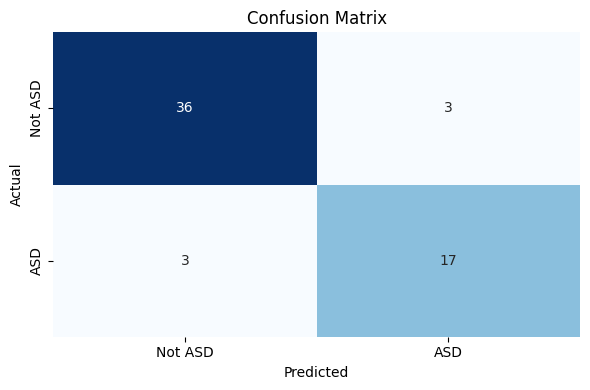

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pyswarm import pso
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("Autism-Child-Data.csv")

# Drop unnecessary columns
data = data.drop(columns=["result", "age_desc", "relation", "jundice", "austim",
                          "contry_of_res", "who completed", "age", "ethnicity",
                          "used_app_before"], errors='ignore')

# Encode categorical columns
for col in data.columns:
    if data[col].dtype == 'object':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))

# Define features and target
X = data.drop(columns=["Class/ASD"])
y = data["Class/ASD"]

# Store original feature names for later use
feature_names = X.columns

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PSO-based wrapper feature selection
def fitness_function(feature_mask):
    mask = np.array(feature_mask) > 0.5
    if np.sum(mask) == 0:
        return 1.0  # Avoid all-zero feature set
    X_sel = X_scaled[:, mask]
    model = SVC(kernel='linear', C=1, class_weight='balanced')
    scores = cross_val_score(model, X_sel, y, cv=5, scoring='accuracy')
    acc = scores.mean()

    # Penalty to keep accuracy within range
    if acc < 0.75:
        return 1 + (0.75 - acc)
    elif acc > 0.85:
        return 1 + (acc - 0.85)
    else:
        return 1 - acc

# PSO bounds
num_features = X.shape[1]
lb = [0] * num_features
ub = [1] * num_features

# Run PSO
best_mask, _ = pso(fitness_function, lb, ub, swarmsize=20, maxiter=30)

# Apply best feature mask
selected_features = np.array(best_mask) > 0.5
X_selected = X_scaled[:, selected_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train final SVM model
model = SVC(kernel='linear', C=1, class_weight='balanced')
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluation
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Output
selected_feature_indices = np.where(selected_features)[0]
selected_feature_names = feature_names[selected_feature_indices]

print("Selected Feature Indices:", selected_feature_indices)
print("Selected Feature Names:", list(selected_feature_names))
print("Training Accuracy:", round(train_accuracy, 4))
print("Test Accuracy:", round(test_accuracy, 4))
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not ASD', 'ASD'],
            yticklabels=['Not ASD', 'ASD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
